In [1]:
import torch.nn as nn
import torch
import pandas as pd
from global_model_periodic import LearnedSimulator_periodic
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')

In [3]:
normalization_stats = {
    "velocity": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e-3, 1e-3]).to(device)},
    "acceleration": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e-3, 1e-3]).to(device)}
}

In [4]:
checkpoint = torch.load("/home/jeanlienhard/Documents/Cell_GNN/GNN for acceleration/Unsupervised/Training/unsupervised_15Conv_256_voronoi/model_50.pth")
new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in checkpoint.items()}
model = LearnedSimulator_periodic(num_dimensions=2, normalization_stats=normalization_stats, device=device)
model.load_state_dict(new_state_dict)
model.to(device)

LearnedSimulator_periodic(
  (graph_network): EncodeProcessDecode(
    (_encoder_network): GraphIndependent(
      (edge_model): Sequential(
        (0): Sequential(
          (0): Linear(in_features=1, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=1, bias=True)
        )
        (1): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
      )
      (node_model): Sequential(
        (0): Sequential(
          (0): Linear(in_features=22, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
        (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
    )
    (_processor_networks): ModuleList(
      (0): GNNModel(
        (gcn_layers): ModuleList(
          (0-14): 15 x NodeGNN()
        )
      )
    )
    (_decoder_network): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_fe

In [5]:
def generate_next_positions(model, device, vrai_pos,n_cells):
    model.eval()
    pos = vrai_pos.copy()
    x = torch.tensor(np.stack(pos, axis=1), dtype=torch.float32).to(device)
    next_position, acc = model(x,n_cells)
    for i in range(len(pos)-1):
        pos[i] = pos[i+1].copy()
    pos[-1] = next_position.cpu().detach().numpy()
    return pos,acc

In [6]:
def create_csv_with_predictions(model,n_cells, device, input_csv, steps=200):
    model.eval()
    loss = []
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    pos = []
    loss_fn = nn.MSELoss()
    vrai_pos = []
    norm_acc = []
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions.copy())
        vrai_pos.append(positions.copy())
    for step in steps_list[5:steps]:
        pos,acc = generate_next_positions(model, device, vrai_pos,n_cells)
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        for i in range(len(vrai_pos)-1):
             vrai_pos[i] = vrai_pos[i+1].copy()
        vrai_pos[-1] = positions.copy()
        print(acc,(vrai_pos[-1]-vrai_pos[-2])[:n_cells]*1e3,pos[-1],vrai_pos[-1])
        if step%1==0:
            norm_acc.append(np.linalg.norm((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[0]))
            loss.append(loss_fn(acc/1e3,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float32).to(device)).cpu().detach().numpy())
    return loss,norm_acc

In [7]:
loss,acc = create_csv_with_predictions(model,10, device, "/home/jeanlienhard/Documents/Cell_GNN/Data/raw_data/positions_5.csv",200)

tensor([[-4.4819e-05,  6.0275e-06],
        [-5.4413e-05, -1.7785e-05],
        [ 1.8902e-05, -6.7972e-05],
        [-6.9549e-05, -3.8430e-05],
        [ 2.1871e-05,  3.4444e-05],
        [-3.2384e-05,  6.3181e-06],
        [-8.0874e-05, -2.0538e-05],
        [ 3.4124e-06, -1.4283e-05],
        [-8.8796e-05, -1.6578e-06],
        [-4.8392e-05, -1.2219e-05]], device='cuda:0', grad_fn=<AddmmBackward0>) [[-0.0657393   0.22330091]
 [-0.2313195  -0.1405411 ]
 [ 0.8932702  -0.5996084 ]
 [-0.4084741  -0.3383836 ]
 [ 0.640949    0.6761551 ]
 [ 0.0660492   0.136315  ]
 [-0.6580542  -0.0616453 ]
 [ 0.6312394   0.0563376 ]
 [-0.7985377   0.19913203]
 [-0.0693832  -0.1510623 ]] [[ 0.63862365  0.01332858]
 [-0.82415116  0.57059914]
 [-0.31464845  0.62194675]
 [ 0.8355119  -0.44685405]
 [-0.6082786   0.72283083]
 [-0.29909435 -0.10670082]
 [-0.9604879  -0.9255547 ]
 [-0.7394375  -0.30360723]
 [ 0.4465921   0.05891411]
 [ 0.3720114   0.85349655]
 [ 0.63862365  2.0133283 ]
 [-0.82415116  2.570599  ]
 

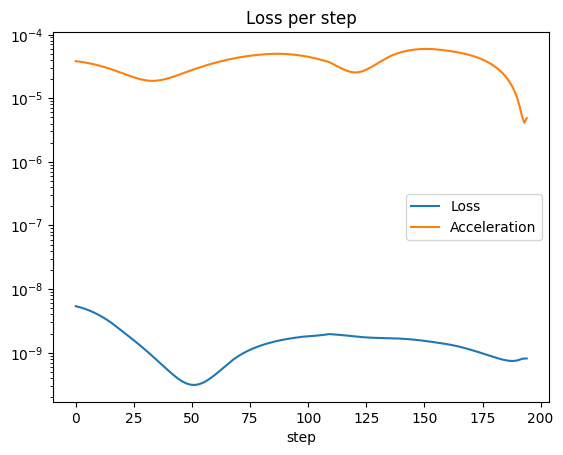

In [8]:
plt.plot(loss, label='Loss')
plt.plot(acc, label='Acceleration')
plt.yscale('log')
plt.xlabel('step')
plt.legend()
plt.title('Loss per step')
plt.show()

In [ ]:
def create_csv_with_real_predictions(model,n_cells, device, input_csv, output_csv, steps=1005):
    model.eval()
    loss = []
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    results = []
    pos = []
    vrai_pos = []
    loss_fn = nn.MSELoss()
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions.copy())
        vrai_pos.append(positions.copy())
    for step in range(steps):#steps_list[5:steps]:
        pos,acc = generate_next_positions(model, device, pos,n_cells)
        print(acc,(vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells]*1e3)
        if step%1==0:
            loss.append(loss_fn(acc/1e3,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float32).to(device)).cpu().detach().numpy())
        for id_, positions in enumerate(pos[-1]):
                results.append({"step": step, "site_index": id_, "x": positions[0], "y": positions[1]})
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")
    return loss

In [29]:
loss = create_csv_with_real_predictions(model,10, device, "/home/jeanlienhard/Documents/Cell_GNN/Data/raw_data/positions_12.csv", "/home/jeanlienhard/Documents/Cell_GNN/GNN for acceleration/Unsupervised/Training/unsupervised_15Conv_256_voronoi/computed_trajectory/computed_positions_12.csv",1005)

tensor([[-4.8522e-05, -4.6473e-05],
        [-3.8259e-05,  1.1001e-05],
        [-8.4521e-05,  1.5505e-05],
        [-1.9411e-05, -3.7521e-05],
        [-5.9647e-05, -1.1131e-05],
        [-3.8940e-05,  3.1821e-05],
        [-1.9740e-05, -6.7800e-06],
        [ 2.2408e-05, -3.3192e-06],
        [-5.5868e-05, -3.3885e-05],
        [-4.5329e-05, -5.0955e-05]], device='cuda:0', grad_fn=<AddmmBackward0>) [[-2.841340e-02 -7.682090e-02]
 [-2.539400e-03  5.155820e-02]
 [-9.792272e-02  5.348430e-02]
 [ 5.119280e-02 -5.050159e-02]
 [-4.246645e-02 -1.257810e-02]
 [ 5.200000e-05  1.237234e-01]
 [ 6.055140e-02  2.254950e-02]
 [ 1.094901e-01  2.145490e-02]
 [-3.488420e-02 -5.300130e-02]
 [-1.506020e-02 -7.986833e-02]]
tensor([[-4.4586e-05, -5.7414e-05],
        [-3.7558e-05,  9.2834e-06],
        [-9.0998e-05,  1.3463e-05],
        [-1.1090e-05, -4.4204e-05],
        [-5.8431e-05, -1.7345e-05],
        [-4.0799e-05,  3.2745e-05],
        [-1.3039e-05, -1.0379e-05],
        [ 3.2745e-05, -6.6422e-06

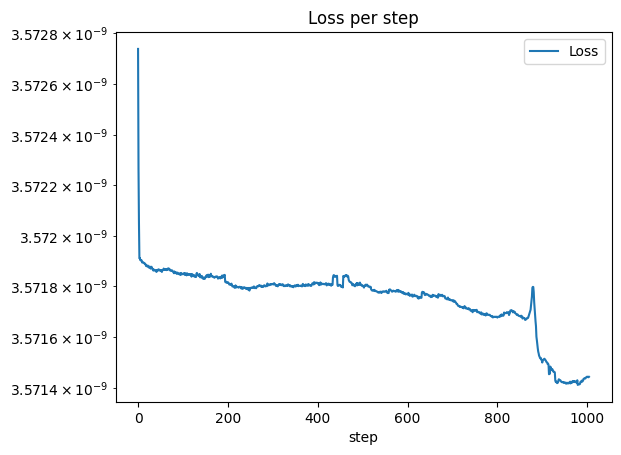

In [30]:
plt.plot(loss, label='Loss')
plt.yscale('log')
plt.xlabel('step')
plt.legend()
plt.title('Loss per step')
plt.show()